# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name="Tennis_Linux_NoVis/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. MMDPG

In [5]:
import random
import torch
from collections import deque
from datetime import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
from maddpg.maddpg_group import Group

group = Group(num_agents=num_agents, state_size=state_size, action_size=action_size, random_seed=2)

In [7]:
def maddpg(n_episodes=1000, print_every=100, target_score=0.5):
    solved = False
    scores_deque = deque(maxlen=print_every)
    scores = []
    
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        episode_scores = np.zeros(num_agents)

        while True:
            group.reset_noise()
            actions = group.act(states)
            
            
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations
            rewards = env_info.rewards
            dones = env_info.local_done
            
            group.step(states, actions, rewards, next_states, dones)
            
            states = next_states
            episode_scores += np.array(rewards)
            if np.any(dones):
                break 
        
        score = episode_scores.max()
        scores_deque.append(score)
        scores.append(score)
        
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)), end="")
        torch.save(group.checkpoint(), f'checkpoints/checkpoint_group.pth')
        
        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            
        if np.mean(scores_deque)>=target_score and not solved:
            solved = True
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            timestamp = dt.now().strftime("%Y-%m-%d_%H:%M:%S")
            torch.save(group.checkpoint(), f'checkpoints/checkpoint_group_{timestamp}.pth')
            break
            
    return scores

In [8]:
scores = maddpg(n_episodes=10000)

Episode 100	Average Score: 0.00
Episode 200	Average Score: 0.01
Episode 300	Average Score: 0.00
Episode 400	Average Score: 0.00
Episode 500	Average Score: 0.00
Episode 600	Average Score: 0.00
Episode 700	Average Score: 0.00
Episode 800	Average Score: 0.04
Episode 900	Average Score: 0.06
Episode 1000	Average Score: 0.08
Episode 1100	Average Score: 0.10
Episode 1200	Average Score: 0.15
Episode 1300	Average Score: 0.22
Episode 1400	Average Score: 0.22
Episode 1500	Average Score: 0.19
Episode 1600	Average Score: 0.22
Episode 1700	Average Score: 0.21
Episode 1800	Average Score: 0.14
Episode 1900	Average Score: 0.11
Episode 2000	Average Score: 0.14
Episode 2100	Average Score: 0.14
Episode 2200	Average Score: 0.19
Episode 2300	Average Score: 0.17
Episode 2400	Average Score: 0.14
Episode 2500	Average Score: 0.13
Episode 2600	Average Score: 0.15
Episode 2700	Average Score: 0.15
Episode 2800	Average Score: 0.19
Episode 2860	Average Score: 0.51
Environment solved in 2860 episodes!	Average Score: 

In [9]:
env.close()

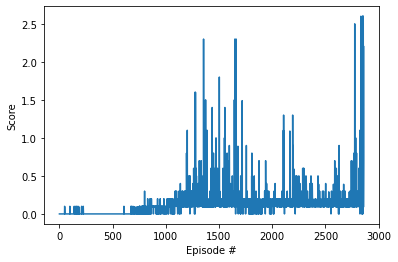

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()